In [119]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import numpy as np
from Allineamento import *

In [137]:
def projectDistZ(x1,x2,y1,y2,d12,z):
    mx = (x2-x1)/d12
    xProj = x1 + mx * z
    
    my = (y2-y1)/d12
    yProj = y1 + my * z
    
    return (xProj, yProj)

def get_theta_angles(x1, y1, x2, y2, d):
    import numpy as np
    thetaX = np.arctan((x2-x1)/d) #rad
    thetaY = np.arctan((y2-y1)/d) #rad
    return (thetaX, thetaY)


def file_loader(run_number):
    """
    Load the data file for a given run number.
    """
    data_path =f'data/TB_T9_2025/run{run_number}.h5'
    # print('opening ', data_path) 
    pos = []
    phs = []
    tmis =[]
    qtots =[]
    nclus = []
    info_pluss =[]
    xinfos =[]
    with h5py.File(data_path, 'r', libver='latest', swmr=True) as hf:
        # print(hf.keys())
        hf["xpos"].shape
        keys = list(hf.keys())
        pos.append(np.array(hf['xpos']))
        phs.append(np.array(hf['digiPH'])) # from 24
        tmis.append(np.array(hf['digiTime'])) # from 24
        qtots.append(np.array(hf['qtot'])) # from 24
        nclus.append(np.array(hf['nclu'])) # from 24
        info_pluss.append(np.array(hf['info_plus']))
        xinfos.append(np.array(hf['xinfo']))
        #for k in hf.keys():
        #    comand = f'{k} = np.array(hf["{k}"])'
            # print(comand)
        #  exec(comand)
    xpos = np.concatenate(pos,axis=0)
    ph = np.concatenate(phs,axis=0)
    tm = np.concatenate(tmis,axis=0)
    qtot = np.concatenate(qtots,axis=0)
    nclu = np.concatenate(nclus,axis=0)
    info_plus = np.concatenate(info_pluss,axis=0)
    xinfo = np.concatenate(xinfos,axis=0)
    # print('xpos shape', xpos.shape)
    # print('N spill: ', info_plus[:,0][-1])
    # print(np.unique(xinfo[:,1]))
        # print('xpos shape', xpos.shape)

    xpos[:,2]= xpos[:,2] - offset_x2 
    xpos[:,3]= xpos[:,3] - offset_y2 
    x1 = xpos[:,1]
    y1 = xpos[:,0]
    x2 = xpos[:,2] 
    y2 = xpos[:,3] 
    x3 = xpos[:,4]
    y3 = xpos[:,5]


    Calibration = False
    if Calibration:
        q = -25.84
        m = 323.4
        ph[:,2]=  (ph[:,2] - q)/m

    xcry, ycry = projectDistZ(x1,x2,y1,y2,d12,d1c)
    theta_x_in, theta_y_in = get_theta_angles(x1, y1, x2, y2, d12)
    theta_x_out, theta_y_out = get_theta_angles(xcry, ycry, x3, y3, dc3)


    ph_calo_photon = ph[:,2]
    ph_cherry1 = ph[:,0]

    return x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
    theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus,xinfo


In [139]:
d12 = 330 ## cm
d23 = 66.8
d1c = 330 + 53.2 #cm
dc3 = 10.7 
d1calo = d1c + 779.2 

offset_x2 =   -0.19494474108211143
offset_y2 =   2.276578722633391 

range_chamber = ((0,10),(0,10))
bins2d = (100,100)
mycmap = 'jet'

opt_hist = {'histtype': 'step', 'lw': 1.5, 'alpha': 0.8}
opts_2d = { "cmap" : mycmap, "bins" : bins2d} # "norm" : mpl.colors.LogNorm()}

th_cherry1 = 20
th_cherry2 = 20


730159 -- N spill: 88 -- events: 34399 -- evs/spill: 391
730160 -- N spill: 81 -- events: 29951 -- evs/spill: 370
730161 -- N spill: 52 -- events: 20134 -- evs/spill: 387
730162 -- N spill: 45 -- events: 17541 -- evs/spill: 390
730163 -- N spill: 67 -- events: 26113 -- evs/spill: 390
730164 -- N spill: 44 -- events: 16531 -- evs/spill: 376
730165 -- N spill: 71 -- events: 27178 -- evs/spill: 383
730166 -- N spill: 33 -- events: 12887 -- evs/spill: 391
730175 -- N spill: 11 -- events: 2714 -- evs/spill: 247


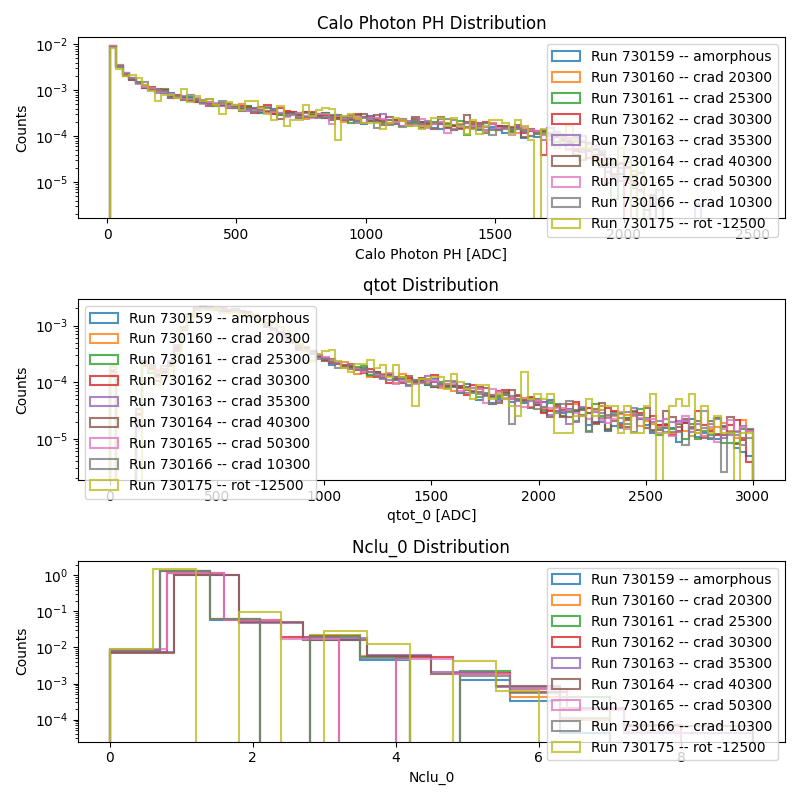

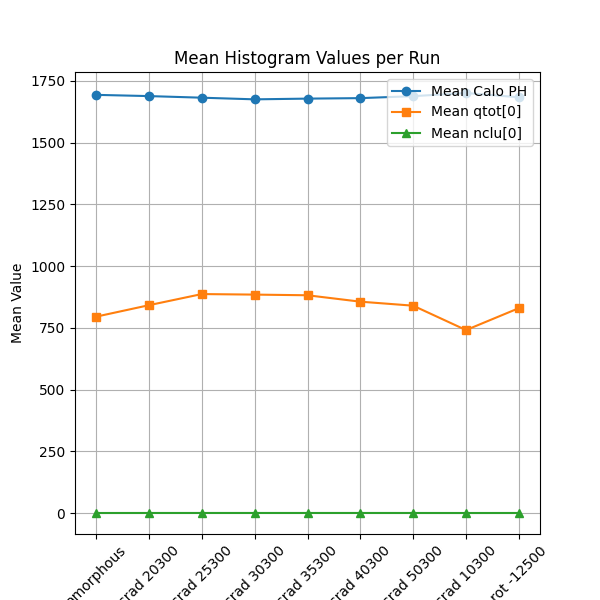

In [ ]:
run_list = [730159,730160,730161,730162,730163,730164,730165,730166,730175] #730157,
labels = [ 'amorphous', 'crad 20300','crad 25300','crad 30300', 'crad 35300', 'crad 40300', 'crad 50300','crad 10300', 'rot -12500'] #'initial guess',

x_cry_cut = [4.6, 4.9]
y_cry_cut = [4.7, 5.15]

fig2,ax2 = plt.subplots(1,figsize=(6, 6)) 
fig,ax = plt.subplots(3,figsize=(8, 8)) 
ph_calo_high = 1500
ph_calo_low = 500

mean_ph_calo = []
mean_qtot0 = []
mean_nclu0 = []

for i, run_number in enumerate(run_list):
    x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
    theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus,xinfo = file_loader(run_number)

    logi = ph_cherry1>th_cherry1 & (xcry>x_cry_cut[0]) & (xcry<x_cry_cut[1]) & (ycry>y_cry_cut[0]) & (ycry<y_cry_cut[1])

    ax[0].hist(ph_calo_photon[logi],bins =100 ,range = (10,2500), label =f'Run {run_number} -- {labels[i]}',density= True, **opt_hist)

    ax[1].hist(qtot[:,0][logi],bins =100 ,range = (0,3000), label =f'Run {run_number} -- {labels[i]}',density= True, **opt_hist)
    
    ax[2].hist(nclu[:,0][logi], label =f'Run {run_number} -- {labels[i]}',density= True, **opt_hist)
    
    logi_mean = logi & ((ph_calo_photon > ph_calo_high)) # | (ph_calo_photon < ph_calo_low))
    mean_ph_calo.append(np.mean(ph_calo_photon[logi_mean]))
    mean_qtot0.append(np.mean(qtot[:, 0][logi_mean]))
    mean_nclu0.append(np.mean(nclu[:, 0][logi_mean]))
    print(f'{run_number} -- N spill: {info_plus[:,0][-1]} -- events: {len(ph_calo_photon)} -- evs/spill: {len(ph_calo_photon)/info_plus[:,0][-1]:.0f}')


titles = ['Calo Photon PH Distribution', 'qtot Distribution', 'Nclu_0 Distribution']
xlabels = ['Calo Photon PH [ADC]', 'qtot_0 [ADC]', 'Nclu_0']
for i in range(3):
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_ylabel('Counts')
    ax[i].set_title(titles[i])
    ax[i].legend()
    ax[i].set_yscale('log')

x = np.arange(len(run_list))  # index for each run


ax2.plot(x, mean_ph_calo, 'o-', label='Mean Calo PH')
ax2.plot(x, mean_qtot0, 's-', label='Mean qtot[0]')
ax2.plot(x, mean_nclu0, '^-', label='Mean nclu[0]')

ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45)
ax2.set_ylabel('Mean Value')
ax2.set_title('Mean Histogram Values per Run')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

730159 -- N spill: 88 -- events: 34399 -- evs/spill: 391
[40004.375] [54999.688]
730159 -- N spill: 88 -- events: 34399 -- evs/spill: 391
730160 -- N spill: 81 -- events: 29951 -- evs/spill: 370
[2.9496064] [20298.98]
730160 -- N spill: 81 -- events: 29951 -- evs/spill: 370
730161 -- N spill: 52 -- events: 20134 -- evs/spill: 387
[1.4137167] [25299.002]
730161 -- N spill: 52 -- events: 20134 -- evs/spill: 387
730162 -- N spill: 45 -- events: 17541 -- evs/spill: 390
[-0.94247776] [30298.746]
730162 -- N spill: 45 -- events: 17541 -- evs/spill: 390
730163 -- N spill: 67 -- events: 26113 -- evs/spill: 390
[-0.38397247] [35300.164]
730163 -- N spill: 67 -- events: 26113 -- evs/spill: 390
730164 -- N spill: 44 -- events: 16531 -- evs/spill: 376
[1.7278759] [40300.609]
730164 -- N spill: 44 -- events: 16531 -- evs/spill: 376
730165 -- N spill: 71 -- events: 27178 -- evs/spill: 383
[1.1170107] [50300.043]
730165 -- N spill: 71 -- events: 27178 -- evs/spill: 383
730166 -- N spill: 33 -- events

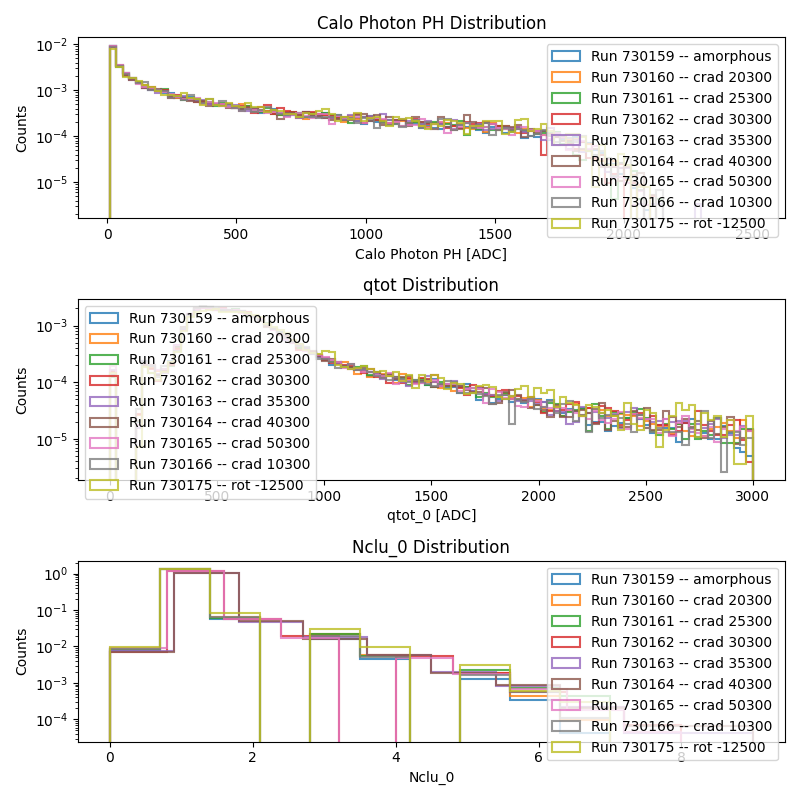

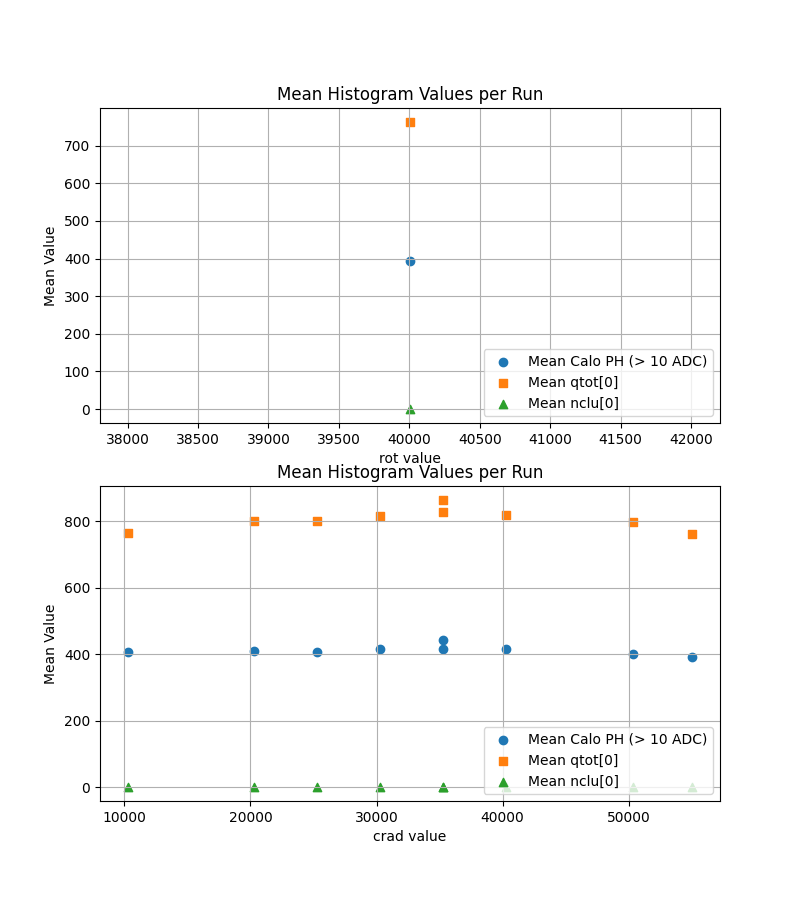

In [140]:
x_cry_cut = [4.6, 4.9]
y_cry_cut = [4.7, 5.15]
ph_calo_high = 10

fig2, ax2 = plt.subplots(2, figsize=(8, 9)) 
fig, ax = plt.subplots(3, figsize=(8, 8)) 

# Containers
rots = []
crads = []
mean_ph_calo = []
mean_qtot0 = []
mean_nclu0 = []

for i, run_number in enumerate(run_list):
    x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
    theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus,xinfo = file_loader(run_number)

    logi = ph_cherry1>th_cherry1 & (xcry>x_cry_cut[0]) & (xcry<x_cry_cut[1]) & (ycry>y_cry_cut[0]) & (ycry<y_cry_cut[1])

    ax[0].hist(ph_calo_photon[logi],bins =100 ,range = (10,2500), label =f'Run {run_number} -- {labels[i]}',density= True, **opt_hist)

    ax[1].hist(qtot[:,0][logi],bins =100 ,range = (0,3000), label =f'Run {run_number} -- {labels[i]}',density= True, **opt_hist)
    
    ax[2].hist(nclu[:,0][logi], label =f'Run {run_number} -- {labels[i]}',density= True, **opt_hist)
    
    logi_mean = logi & ((ph_calo_photon > ph_calo_high)) # | (ph_calo_photon < ph_calo_low))
    mean_ph_calo.append(np.mean(ph_calo_photon[logi_mean]))
    mean_qtot0.append(np.mean(qtot[:, 0][logi_mean]))
    mean_nclu0.append(np.mean(nclu[:, 0][logi_mean]))
    print(f'{run_number} -- N spill: {info_plus[:,0][-1]} -- events: {len(ph_calo_photon)} -- evs/spill: {len(ph_calo_photon)/info_plus[:,0][-1]:.0f}')

    # Extract xinfo[:,1] unique value
    rot = np.unique(xinfo[:, 0])
    crad = np.unique(xinfo[:, 1])
    print(rot, crad)
    rots.append(rot[0])
    crads.append(crad[0])

    # Info
    print(f'{run_number} -- N spill: {info_plus[:,0][-1]} -- events: {len(ph_calo_photon)} -- evs/spill: {len(ph_calo_photon)/info_plus[:,0][-1]:.0f}')

# Plot formatting
titles = ['Calo Photon PH Distribution', 'qtot Distribution', 'Nclu_0 Distribution']
xlabels = ['Calo Photon PH [ADC]', 'qtot_0 [ADC]', 'Nclu_0']

for i in range(3):
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_ylabel('Counts')
    ax[i].set_title(titles[i])
    ax[i].legend()
    ax[i].set_yscale('log')

# Mean plot
ax2[0].scatter(rots[:1], mean_ph_calo[:1], marker='o', label=f'Mean Calo PH (> {ph_calo_high} ADC)')
ax2[0].scatter(rots[:1], mean_qtot0[:1], marker='s', label='Mean qtot[0]')
ax2[0].scatter(rots[:1], mean_nclu0[:1], marker='^', label='Mean nclu[0]')
# ax2[0].set_xticks(rots[:1])
# ax2[0].set_xticklabels([str(int(val)) for val in rots], rotation=45)

ax2[0].set_xlabel('rot value')
ax2[0].set_ylabel('Mean Value')
ax2[0].set_title('Mean Histogram Values per Run')
ax2[0].legend(loc ='lower right')
ax2[0].grid(True)

ax2[1].scatter(crads, mean_ph_calo, marker='o', label=f'Mean Calo PH (> {ph_calo_high} ADC)')
ax2[1].scatter(crads, mean_qtot0, marker='s', label='Mean qtot[0]')
ax2[1].scatter(crads, mean_nclu0, marker='^', label='Mean nclu[0]')
# ax2[1].set_xticks(crad)
# ax2[1].set_xticklabels([str(int(val)) for val in crads], rotation=45)

ax2[1].set_xlabel('crad value')
ax2[1].set_ylabel('Mean Value')
ax2[1].set_title('Mean Histogram Values per Run')
ax2[1].legend(loc ='lower right')
ax2[1].grid(True)

plt.tight_layout()
plt.show()


## code for a scan (to be optimized for theta in )

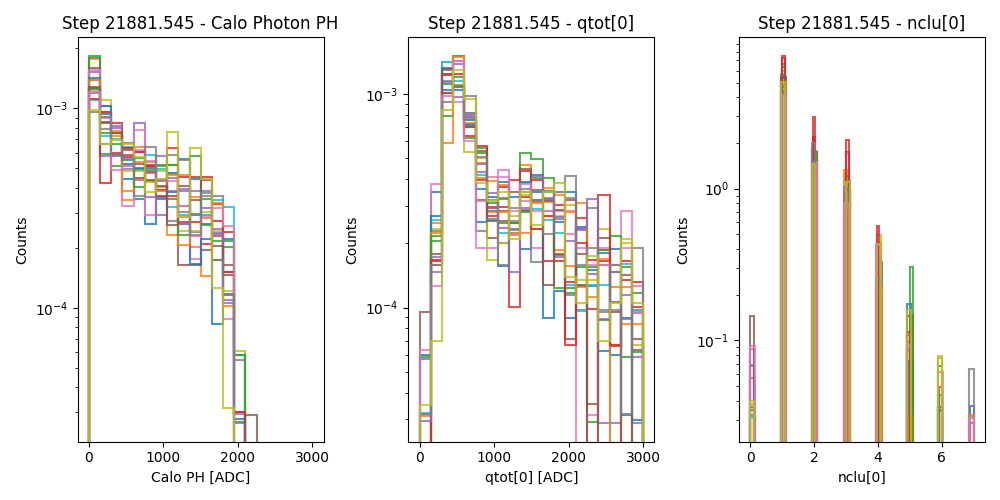

In [142]:
scan_number = 730158 

isrot = False
iscrad = True

# Caricamento dei dati (assumendo 1 solo run)
x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus,xinfo = file_loader(scan_number)

if iscrad:
    scan_angle = xinfo[:,1]
else:
    scan_angle = xinfo[:,0]

unique_steps = np.unique(scan_angle)
n_steps = len(unique_steps)

fig, axs = plt.subplots(1, 3, figsize=(10,5))

for i, step in enumerate(unique_steps):
    logi = (ph_cherry1 > th_cherry1) & (scan_angle == step) & (xcry>x_cry_cut[0]) & (xcry<x_cry_cut[1]) & (ycry>y_cry_cut[0]) & (ycry<y_cry_cut[1])
        

    if np.sum(logi) == 0:
        continue

    axs[0].hist(ph_calo_photon[logi], bins=20, range=(0, 3000), label=f'Step {step}', density=True, **opt_hist)
    axs[1].hist(qtot[:, 0][logi], bins=20, range=(0, 3000), label=f'Step {step}', density=True, **opt_hist)
    axs[2].hist(nclu[:, 0][logi], bins=50, label=f'Step {step}', density=True, **opt_hist)

    axs[0].set_title(f'Step {step} - Calo Photon PH')
    axs[1].set_title(f'Step {step} - qtot[0]')
    axs[2].set_title(f'Step {step} - nclu[0]')

    for j in range(3):
        axs[j].set_yscale('log')
        # axs[j].legend()
        axs[j].set_xlabel(['Calo PH [ADC]', 'qtot[0] [ADC]', 'nclu[0]'][j])
        axs[j].set_ylabel('Counts')

plt.tight_layout()
plt.show()


In [ ]:
# Storage for plotting
steps = []
mean_ph_calo = []
mean_qtot0 = []
mean_nclu0 = []

sum_ph_calo = []
sum_qtot0 = []
sum_nclu0 = []

for step in unique_steps:
    logi = (ph_cherry1 > th_cherry1) & (scan_angle == step) & (xcry>x_cry_cut[0]) & (xcry<x_cry_cut[1]) & (ycry>y_cry_cut[0]) & (ycry<y_cry_cut[1])

    if np.sum(logi) == 0:
        continue
    if iscrad:
        theta_in = theta_y_in[logi]
    else:
        theta_in = theta_x_in[logi]
    steps.append(step)
    # steps.append(step + theta_in)
    
    ph = ph_calo_photon[logi]
    qt = qtot[:, 0][logi]
    nc = nclu[:, 0][logi]

    mean_ph_calo.append(np.mean(ph))
    mean_qtot0.append(np.mean(qt))
    mean_nclu0.append(np.mean(nc))

    sum_ph_calo.append(np.sum(ph))
    sum_qtot0.append(np.sum(qt))
    sum_nclu0.append(np.sum(nc))

# Convert to numpy arrays
steps = np.array(steps)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Average value plot
axs[0].plot(steps, mean_ph_calo, 'o-', label='Mean Calo Photon PH')
axs[0].plot(steps, mean_qtot0, 's-', label='Mean qtot[0]')
# axs[0].plot(steps, mean_nclu0, '^-', label='Mean nclu[0]')
axs[0].set_ylabel('Average Value')
axs[0].set_title('Average Value vs Step Number')
axs[0].legend()
axs[0].grid(True)

# Integral (sum) plot
axs[1].plot(steps, sum_ph_calo, 'o-', label='Sum Calo Photon PH')
axs[1].plot(steps, sum_qtot0, 's-', label='Sum qtot[0]')
# axs[1].plot(steps, sum_nclu0, '^-', label='Sum nclu[0]')
axs[1].set_xlabel('Angle value')
axs[1].set_ylabel('Integral (Sum of Entries)')
axs[1].set_title('Histogram Integral vs Step Number')
axs[1].legend()
axs[1].grid(True)

fig.savefig(f'plots/{scan_number}_step_scan.png', dpi=300)
plt.tight_layout()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

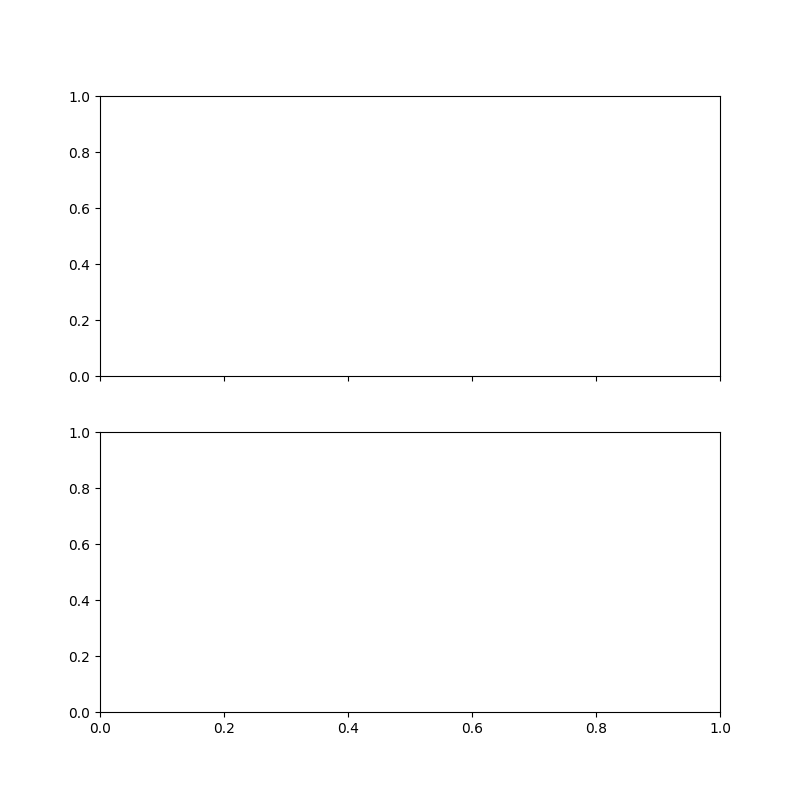

In [ ]:
steps = []
mean_ph_calo = []
mean_qtot0 = []
mean_nclu0 = []

sum_ph_calo = []
sum_qtot0 = []
sum_nclu0 = []
unique_steps = np.unique(scan_angle)
n_steps = len(unique_steps)
for step in unique_steps:
    logi = (ph_cherry1 > th_cherry1) & (scan_angle == step) & (xcry>x_cry_cut[0]) & (xcry<x_cry_cut[1]) & (ycry>y_cry_cut[0]) & (ycry<y_cry_cut[1])

    if np.sum(logi) == 0:
        continue

    # steps.append(step+theta_y_in)
    # steps.append(step)

    ph = ph_calo_photon[logi]
    qt = qtot[:, 0][logi]
    nc = nclu[:, 0][logi]

    mean_ph_calo.append(np.mean(ph))
    mean_qtot0.append(np.mean(qt))
    mean_nclu0.append(np.mean(nc))

    sum_ph_calo.append(np.sum(ph))
    sum_qtot0.append(np.sum(qt))
    sum_nclu0.append(np.sum(nc))

# Convert to numpy arrays
steps = np.array(steps)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Average value plot
axs[0].plot(steps, mean_ph_calo, 'o-', label='Mean Calo Photon PH')
axs[0].plot(steps, mean_qtot0, 's-', label='Mean qtot[0]')
axs[0].plot(steps, mean_nclu0, '^-', label='Mean nclu[0]')
axs[0].set_ylabel('Average Value')
axs[0].set_title('Average Value vs Step Number')
axs[0].legend()
axs[0].grid(True)

# Integral (sum) plot
axs[1].plot(steps, sum_ph_calo, 'o-', label='Sum Calo Photon PH')
axs[1].plot(steps, sum_qtot0, 's-', label='Sum qtot[0]')
axs[1].plot(steps, sum_nclu0, '^-', label='Sum nclu[0]')
axs[1].set_xlabel('Step Number')
axs[1].set_ylabel('Integral (Sum of Entries)')
axs[1].set_title('Histogram Integral vs Step Number')
axs[1].legend()
axs[1].grid(True)

fig.savefig(f'plots/{scan_number}_step_scan.png', dpi=300)
plt.tight_layout()
plt.show()
